**Import Dependecies**

**Import Data from Google Cloud Bucket**

In [1]:
!pip install gcsfs
!pip install -q tensorflow==2.0.0-alpha0

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import os

from sklearn.preprocessing import MinMaxScaler

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Input, Dense, GRU, Embedding
from tensorflow.keras.optimizers import RMSprop
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau, TensorBoard

     |████████████████████████████████| 61kB 2.9MB/s 
  Stored in directory: /root/.cache/pip/wheels/9f/0f/b9/5bc5222756d121ccace51ab3084a1c733380908a4e2f939038
Successfully built gcsfs
     |████████████████████████████████| 79.9MB 51.7MB/s 
     |████████████████████████████████| 3.0MB 43.3MB/s 
     |████████████████████████████████| 61kB 29.0MB/s 
     |████████████████████████████████| 419kB 55.5MB/s 


In [0]:
from google.colab import auth
auth.authenticate_user()

In [3]:
project_id = 'hybrid-circle-195115'
!gcloud config set project hybrid-circle-195115

Updated property [core/project].


To take a quick anonymous survey, run:
  $ gcloud alpha survey



In [4]:
df_TimeSeries = pd.read_csv('gs://maia_cws_timeseries/TS.csv')
df_TimeSeries.values.shape

W0519 05:14:09.756837 140275684697984 _default.py:280] No project ID could be determined. Consider running `gcloud config set project` or setting the GOOGLE_CLOUD_PROJECT environment variable


(1414436, 15)

In [5]:
df_FilledTS = df_TimeSeries.ffill()
df_FilledTS = df_FilledTS.bfill()

df_FilledTS.drop(['AB1_C2_RespOP', 'AB1_C2_rRespOP'], axis=1, inplace=True)

df_FilledTS.head()

,ds,AB1_C2_OP,AB1_C7B_OP,SCE_OP,SCE_NH3,SCE_NO3,PI_Flow,PE_Flow,PE_AB1Flow,VFA_AB1Flow,WAS_Level,CENT1_Level,CENT2_Level
0,2018-01-01 00:01:00,14.124451,0.8,0.0625,14.84375,5.94375,26.549999,27.269531,6.726562,0.0,5.179688,16.299999,16.4
1,2018-01-01 00:02:00,14.124451,0.8,0.0625,14.84375,5.94375,26.549999,27.269531,6.726562,0.0,5.179688,16.299999,16.4
2,2018-01-01 00:04:00,14.124451,0.8,0.0625,14.84375,5.94375,26.549999,27.269531,6.726562,0.0,5.179688,16.299999,16.4
3,2018-01-01 00:06:00,14.124519,0.8,0.0625,14.84375,5.94375,26.549999,27.269531,6.746094,0.0,5.170312,16.299999,16.4
4,2018-01-01 00:07:00,14.124519,0.8,0.0625,14.84375,5.94375,26.250000,27.269531,6.746094,0.0,5.170312,16.200001,16.4


In [6]:
df_FilledTS = df_FilledTS.drop_duplicates(['ds'], keep ='first')
df_FilledTS.values.shape

(1413011, 13)

This file with spoardic recordings approx every 5 min. Will need to be rounded and resampled in future iterations.


In [0]:
#df_FilledTS['ds'] = pd.to_datetime(df_FilledTS['ds'])
#df_TimeSeries = df_TimeSeries.set_index('ds')
#df_TimeSeries['SCE_OP'].plot()

In [0]:
df_FilledTS['time'] =  pd.to_datetime(df_FilledTS['ds'], format='%Y-%m-%d %H:%M:%S')
df_FilledTS = df_FilledTS.set_index('time')
df_FilledTS.drop(['ds'], axis=1, inplace=True)

In [9]:
df_FilledTS = df_FilledTS.resample('30S').bfill()
df_FilledTS.head()

,AB1_C2_OP,AB1_C7B_OP,SCE_OP,SCE_NH3,SCE_NO3,PI_Flow,PE_Flow,PE_AB1Flow,VFA_AB1Flow,WAS_Level,CENT1_Level,CENT2_Level
time,,,,,,,,,,,,
2018-01-01 00:01:00,14.124451,0.8,0.0625,14.84375,5.94375,26.549999,27.269531,6.726562,0.0,5.179688,16.299999,16.4
2018-01-01 00:01:30,14.124451,0.8,0.0625,14.84375,5.94375,26.549999,27.269531,6.726562,0.0,5.179688,16.299999,16.4
2018-01-01 00:02:00,14.124451,0.8,0.0625,14.84375,5.94375,26.549999,27.269531,6.726562,0.0,5.179688,16.299999,16.4
2018-01-01 00:02:30,14.124451,0.8,0.0625,14.84375,5.94375,26.549999,27.269531,6.726562,0.0,5.179688,16.299999,16.4
2018-01-01 00:03:00,14.124451,0.8,0.0625,14.84375,5.94375,26.549999,27.269531,6.726562,0.0,5.179688,16.299999,16.4


In [10]:
df_FilledTS5 = df_FilledTS.resample('5T').bfill()
df_FilledTS5.head()

,AB1_C2_OP,AB1_C7B_OP,SCE_OP,SCE_NH3,SCE_NO3,PI_Flow,PE_Flow,PE_AB1Flow,VFA_AB1Flow,WAS_Level,CENT1_Level,CENT2_Level
time,,,,,,,,,,,,
2018-01-01 00:00:00,14.124451,0.8,0.06250,14.843750,5.94375,26.549999,27.269531,6.726562,0.0,5.179688,16.299999,16.400000
2018-01-01 00:05:00,14.124519,0.8,0.06250,14.843750,5.94375,26.549999,27.269531,6.746094,0.0,5.170312,16.299999,16.400000
2018-01-01 00:10:00,14.249565,0.8,0.05625,14.843750,5.96250,26.250000,26.359375,6.722656,0.0,5.179688,16.200001,16.400000
2018-01-01 00:15:00,14.249611,0.8,0.05000,14.875001,5.96250,26.250000,26.378906,6.859375,0.0,5.175000,16.200001,16.299999
2018-01-01 00:20:00,14.395607,0.9,0.05625,14.875001,5.96250,25.950001,26.382812,6.765625,0.0,5.175000,16.200001,16.299999


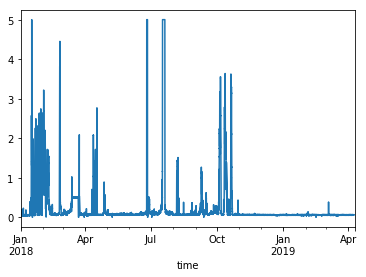

In [11]:
df_FilledTS5['SCE_OP'].plot()

This is to help with some predictions in terms of seasonal and daily patterns!

In [0]:
df_FilledTS5['Day'] = df_FilledTS5.index.dayofyear
df_FilledTS5['Hour'] = df_FilledTS5.index.hour

Select response variable

In [0]:
Response_Variables = ['SCE_OP']

Time shift - this may not be necessary for what we want to do as we predict future for other variables as well. 

In [0]:
shift_days = 1
shift_steps = shift_days * 24 * 12 #number of 10 minute increments in a day

In [0]:
df_response = df_FilledTS5[Response_Variables].shift(-shift_steps)

Convert to NumPy arrays that are inputs to neural network

In [0]:
x_data = df_FilledTS5.values[0:-shift_steps]

In [17]:
print(type(x_data))
print("Shape:", x_data.shape)

<class 'numpy.ndarray'>
Shape: (133632, 14)


In [0]:
y_data = df_response.values[:-shift_steps]

In [19]:
print(type(y_data))
print("Shape:", y_data.shape)

<class 'numpy.ndarray'>
Shape: (133632, 1)


In [20]:
num_data = len(x_data)
num_data

133632

Determine training-set split

In [0]:
train_split = 0.9

Number of observations in training set

In [22]:
num_train = int(train_split * num_data)
num_train

120268

This is number of observations in test-set

In [23]:
num_test = num_data - num_train
num_test

13364

Input signals for the training and test sets:

In [24]:
x_train = x_data[0:num_train]
x_test = x_data[num_train:]
len(x_train) + len(x_test)

133632

In [25]:
y_train = y_data[0:num_train]
y_test = y_data[num_train:]
len(y_train) + len(y_test)

133632

Number of input signals:

In [26]:
num_x_signals = x_data.shape[1]
num_x_signals

14

Number of output-signals

In [27]:
num_y_signals = y_data.shape[1]
num_y_signals

1

Need to scale data to assist neural networks

In [28]:
print("Min:", np.min(x_train))
print("Max:", np.max(x_train))

Min: -7.5
Max: 365.0


In [0]:
x_scaler = MinMaxScaler()

In [0]:
x_train_scaled = x_scaler.fit_transform(x_train)

In [31]:
print("Min:", np.min(x_train_scaled))
print("Max:", np.max(x_train_scaled))

Min: 0.0
Max: 1.0


In [32]:
print("Min:", np.min(x_test))
print("Max:", np.max(x_test))

Min: 0.0
Max: 220.78961181640625


In [0]:
x_test_scaled = x_scaler.transform(x_test)

In [34]:
print("Min:", np.min(x_test_scaled))
print("Max:", np.max(x_test_scaled))

Min: 0.0
Max: 1.0


In [0]:
y_scaler = MinMaxScaler()
y_train_scaled = y_scaler.fit_transform(y_train)
y_test_scaled = y_scaler.transform(y_test)

Data Generation!

In [36]:
print(x_train_scaled.shape)
print(y_train_scaled.shape)

(120268, 14)
(120268, 1)


Need to create a generator to generate batches of data to train/test

In [0]:
def batch_generator(batch_size, sequence_length):
    """
    Generator function for creating random batches of training-data.
    """

    # Infinite loop.
    while True:
        # Allocate a new array for the batch of input-signals.
        x_shape = (batch_size, sequence_length, num_x_signals)
        x_batch = np.zeros(shape=x_shape, dtype=np.float16)

        # Allocate a new array for the batch of output-signals.
        y_shape = (batch_size, sequence_length, num_y_signals)
        y_batch = np.zeros(shape=y_shape, dtype=np.float16)

        # Fill the batch with random sequences of data.
        for i in range(batch_size):
            # Get a random start-index.
            # This points somewhere into the training-data.
            idx = np.random.randint(num_train - sequence_length)
            
            # Copy the sequences of data starting at this index.
            x_batch[i] = x_train_scaled[idx:idx+sequence_length]
            y_batch[i] = y_train_scaled[idx:idx+sequence_length]
        
        yield (x_batch, y_batch)

Change batch size to depending on GPU/RAM

In [0]:
batch_size = 256

Sequence_length refers to how many time steps it trains on. Here is for 72 hours.

In [39]:
sequence_length = 12 * 72
sequence_length

864

Batch generator

In [0]:
generator = batch_generator(batch_size=batch_size,
                            sequence_length=sequence_length)

Test the generator on one set

In [0]:
x_batch, y_batch = next(generator)

In [42]:
print(x_batch.shape)
print(y_batch.shape)

(256, 864, 14)
(256, 864, 1)


Random batch of 256 sequences with each sequence having 864 observations, and each observation having 14 inputs and 1 output

Plot on of the input signals as an example

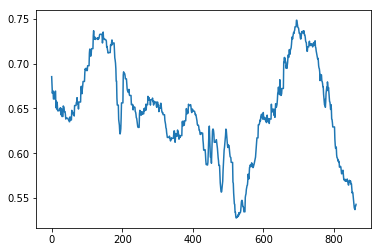

In [43]:
batch = 0   # First sequence in the batch.
signal = 0  # First signal from the 20 input-signals.
seq = x_batch[batch, :, signal]
plt.plot(seq)

Plot one section of an output signal (72 hours)

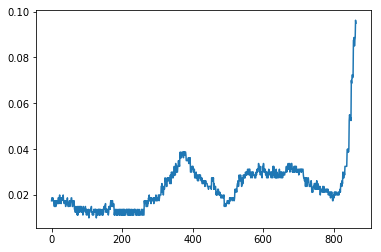

In [44]:
seq = y_batch[batch, :, signal]
plt.plot(seq)

Create a validation set!

In [0]:
validation_data = (np.expand_dims(x_test_scaled, axis=0),
                   np.expand_dims(y_test_scaled, axis=0))

Create the Recurrent Neural Network

In [0]:
model = Sequential()

Not add the gated recurrent unit. This will have 512 to start? Need to play with this

In [0]:
model.add(GRU(units=512,
              return_sequences=True,
              input_shape=(None, num_x_signals,)))

In [0]:
model.add(Dense(num_y_signals, activation='sigmoid'))

A problem with using the Sigmoid activation function, is that we can now only output values in the same range as the training-data. We can use a linear activation function on the output instead. This allows for the output to take on arbitrary values. It might work with the standard initialization for a simple network architecture, but for more complicated network architectures e.g. with more layers, it might be necessary to initialize the weights with smaller values to avoid NaN values during training. May need to experiment with this to get it working.

In [0]:
if False:
    from tensorflow.keras.initializers import RandomUniform

    # Maybe use lower init-ranges.
    init = RandomUniform(minval=-0.05, maxval=0.05)

    model.add(Dense(num_y_signals,
                    activation='linear',
                    kernel_initializer=init))

Loss Function!
We will use Mean Squared Error (MSE) as the loss-function that will be minimized. 
At the beginning of a sequence, the model has only seen input-signals for a few time-steps, so its generated output may be very inaccurate. Using the loss-value for the early time-steps may cause the model to distort its later output. We therefore give the model a "warmup-period" of 50 time-steps where we don't use its accuracy in the loss-function, in hope of improving the accuracy for later time-steps. NEED TO WORK ON GETTING WARMUP FUNCTION WORKING!!!

In [0]:
warmup_steps = 50

In [0]:
def loss_mse_warmup(y_true, y_pred):
    """
    Calculate the Mean Squared Error between y_true and y_pred,
    but ignore the beginning "warmup" part of the sequences.
    
    y_true is the desired output.
    y_pred is the model's output.
    """

    # The shape of both input tensors are:
    # [batch_size, sequence_length, num_y_signals].

    # Ignore the "warmup" parts of the sequences
    # by taking slices of the tensors.
    y_true_slice = y_true[:, warmup_steps:, :]
    y_pred_slice = y_pred[:, warmup_steps:, :]

    # These sliced tensors both have this shape:
    # [batch_size, sequence_length - warmup_steps, num_y_signals]

    # Calculate the MSE loss for each value in these tensors.
    # This outputs a 3-rank tensor of the same shape.
    loss = tf.keras.losses.MeanAbsolutePercentageError(y_true=y_true_slice,
                                        y_pred=y_pred_slice)

    # Keras may reduce this across the first axis (the batch)
    # but the semantics are unclear, so to be sure we use
    # the loss across the entire tensor, we reduce it to a
    # single scalar with the mean function.
    loss_mean = tf.reduce_mean(loss)

    return loss_mean

Compile Model!

In [0]:
optimizer = RMSprop(lr=1e-3)

In [0]:
model.compile(loss=tf.keras.losses.MeanSquaredError(), optimizer=optimizer)

In [54]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
unified_gru (UnifiedGRU)     (None, None, 512)         811008    
_________________________________________________________________
dense (Dense)                (None, None, 1)           513       
Total params: 811,521
Trainable params: 811,521
Non-trainable params: 0
_________________________________________________________________


Callback Functions

In [0]:
path_checkpoint = '23_checkpoint.keras'
callback_checkpoint = ModelCheckpoint(filepath=path_checkpoint,
                                      monitor='val_loss',
                                      verbose=1,
                                      save_weights_only=True,
                                      save_best_only=True)

THis is callback for stopping optimization when performance worsens on validation set

In [0]:
callback_early_stopping = EarlyStopping(monitor='val_loss',
                                        patience=5, verbose=1)

Callback for writing the TensorBoard log during training

In [0]:
callback_tensorboard = TensorBoard(log_dir='./23_logs/',
                                   histogram_freq=0,
                                   write_graph=False)

This callback reduces the learning-rate for the optimizer if the validation-loss has not improved since the last epoch (as indicated by patience=0). The learning-rate will be reduced by multiplying it with the given factor. We set a start learning-rate of 1e-3 above, so multiplying it by 0.1 gives a learning-rate of 1e-4. We don't want the learning-rate to go any lower than this.

In [0]:
callback_reduce_lr = ReduceLROnPlateau(monitor='val_loss',
                                       factor=0.1,
                                       min_lr=1e-4,
                                       patience=0,
                                       verbose=1)

In [0]:
callbacks = [callback_early_stopping,
             callback_checkpoint,
             callback_tensorboard,
             callback_reduce_lr]

TRAIN THE NETWORK!!!



In [0]:
%%time
model.fit_generator(generator=generator,
                    epochs=20,
                    steps_per_epoch=100,
                    validation_data=validation_data,
                    callbacks=callbacks)

Epoch 1/20
 99/100 [============================>.] - ETA: 24s - loss: 0.0171
Epoch 00001: val_loss improved from inf to 0.00039, saving model to 23_checkpoint.keras
100/100 [==============================] - 2466s 25s/step - loss: 0.0170 - val_loss: 3.8858e-04
Epoch 2/20
 46/100 [============>.................] - ETA: 21:55 - loss: 0.0118